# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

## Preparations

In [7]:
# Load general utilities
# ----------------------
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Load regressors
# --------------
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn import linear_model

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
# import pixiedust
pd.options.mode.chained_assignment = None #'warn'
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return(np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

    
    
# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out



# Define a default random seed and an output file
default_seed = 1
output_file = "output_sample"

# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [19]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open("clean_data.pickle", "rb" ) )
data.reset_index(drop=True,inplace=True)

In [18]:
discrete_features

['grade',
 'emp_length',
 'purpose',
 'verification_status',
 'home_ownership',
 'term']

In [20]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data['outcome'] = (data['loan_status']=='Charged Off')|(data['loan_status']=='Default')

# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Create a matrix of features and outcomes, with dummies. 
# Record the names of the dummies for later use
X_continuous = data[continuous_features].values
X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate((X_continuous, X_discrete), axis=1)
y = data.outcome.values

## Create index groups for temporal training/test split
# groupidx={v:i for i,v in enumerate(data.groupby(by='issue_d').indices.keys())}
# data['group']=data['issue_d'].map(groupidx)

# 2.1 Random train/test split
# Randomly assign each row to a training and test set. 
# We do this now because we will be fitting a variety 
# of models on various time periods, and we would like 
# every period to use the *same* training/test split
## create the train columns where the value is True if 
# it is a train instance and False otherwise. Hint: use 
# np.random.choice with 70% for training and 30% for testing
np.random.seed(default_seed)
data['train'] = [False]*len(data)
data['train'][np.random.choice(len(data),int(len(data)*0.7),replace=False)]=True

# 2.2 Temporal training/test split
# find the cut-off date (70%/30%)
# data.sort_values(by="issue_d",inplace=True)
# data.reset_index(drop=True,inplace=True)
# data['issue_d'][int(len(data)*0.7)]
# print(len(data[data['issue_d']>datetime.date(2015, 11, 1)])/len(data))
# print(len(data[data['issue_d']>datetime.date(2015, 10, 1)])/len(data))
# data['train'] = [False]*len(data)
# data['train'][data['issue_d']<=datetime.date(2015, 10, 1)]=True

train = data.train.values

## Prepare functions to fit and evaluate models

In [21]:
def prepare_data(data = data, 
                    data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
    
    # Filter down the data to the required date range, 
    # and downsample as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [22]:
def fit_classification(model, data_dict, 
                          cv_parameters = {},
                          cv_mode = 'random',
                          model_name = None,
                          random_state = default_seed,
                          avg_100 = False,
                          data = data,
                          feature_subset = None,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
    
    np.random.seed(random_state)

    # -------------------------------------
    #   100 independent train/test splits 
    # -------------------------------------
    
    if avg_100:
        
        accuracy_100 = []
        best_threshold_100 = []
        probs_predicted = False
        
        start_time=time.time()
        
        for i in range(100):
            np.random.seed(i)
            data['train'] = [False]*len(data)
            data['train'][np.random.choice(len(data),int(len(data)*0.7),replace=False)]=True
            train = data.train.values
            data_dict = prepare_data(feature_subset = feature_subset)
            
            X_train = data_dict['X_train']
            y_train = data_dict['y_train']
            X_test = data_dict['X_test']
            y_test = data_dict['y_test']
        
            if cv_mode=='random':
                cv_model = GridSearchCV(model, cv_parameters)
                cv_model.fit(X_train, y_train)

            else:
                print('The input CV mode does not exist')
                raise
                
            best_model = cv_model.best_estimator_
    
            # If possible, make probability predictions
            try:
                y_pred_probs = best_model.predict_proba(X_test)[:,1]
                probs_predicted = True
            except:
                probs_predicted = False

            # Make predictions; if we were able to find probabilities, use
            # the threshold that maximizes the accuracy in the training set.
            # If not, just use the learner's predict function
            if probs_predicted:
                y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
                fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

                true_pos_train = tpr_train*(y_train.sum())
                true_neg_train = (1 - fpr_train) *(1-y_train).sum()

                best_threshold_index = np.argmax(true_pos_train + true_neg_train)
                best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
                best_threshold_100.append(best_threshold)

                y_pred = (y_pred_probs > best_threshold)
            else:
                y_pred = best_model.predict(X_test)
            
            accuracy_100.append(accuracy_score(y_test, y_pred))
                
        end_time=time.time()    
        
        if print_to_screen:
            print("="*54)
            print(" "*14+"Average Performance Report")
            print("="*54)
            
            print("Running time for 100 models: " + time.strftime("%H hours %M min %S sec", time.gmtime(end_time - start_time)))
            if probs_predicted:
                print("Average accuracy-maximizing threshold: ({:.5f}, {:.5f})".format(np.array(best_threshold_100).mean(), np.array(best_threshold_100).std()))
            
            print("Average accuracy: ({:.5f}, {:.5f})".format(np.array(accuracy_100).mean(), np.array(accuracy_100).std()))
            print("")
        
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    X_train = data_dict['X_train']
    y_train = data_dict['y_train']

    X_test = data_dict['X_test']
    y_test = data_dict['y_test']

    filter_train = data_dict['train_set']    

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    if cv_mode=='random':
        cv_model = GridSearchCV(model, cv_parameters)
        start_time = time.time()
        cv_model.fit(X_train, y_train)
        end_time = time.time()

    elif cv_mode=='time':
        cv_model = GridSearchCV(model, cv_parameters, cv=GroupKFold(n_splits=5))
        start_time = time.time()
        try:
            cv_model.fit(X_train, y_train, groups=data['issue_d'][data_dict['train_set']])
        except:
            print('The CV group is incorrect')
            raise
        end_time = time.time()

    else:
        print('The input CV mode does not exist')
        raise
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:
        if model_name != None:
            print("="*54)
            print(" "*14+"Model: {}".format(model_name))
            print("="*54)

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            # plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the test set
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # -----------------------------------
    #   Step 4 - Output results to file
    # -----------------------------------
    
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Q1. Train and Test different machine learning classification models (Random train/test split)

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [51]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

              Model: Naive Bayes
Fit time: 0.3 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.773558267776948
Accuracy:  0.8912
              precision    recall  f1-score   support

  No default     0.9489    0.9174    0.9329     16481
     Default     0.6652    0.7684    0.7131      3519

   micro avg     0.8912    0.8912    0.8912     20000
   macro avg     0.8070    0.8429    0.8230     20000
weighted avg     0.8989    0.8912    0.8942     20000



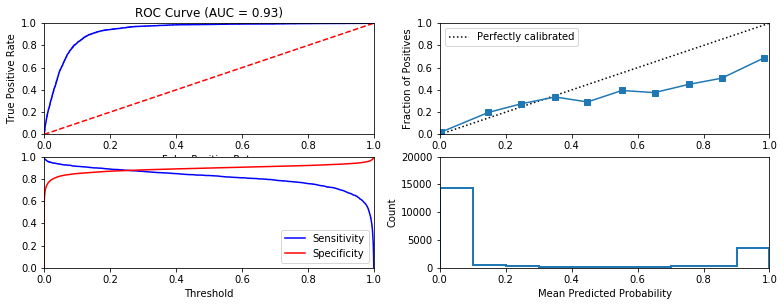


Similarity to LC grade ranking:  0.3306649087357692
Brier score: 0.09646409657828459
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.88893333]


In [13]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, {}, 'random', "Naive Bayes")

### $l_1$ regularized logistic regression

              Model: l1 Logistic Regression
Fit time: 27.94 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.428550851873202
Accuracy:  0.89615
              precision    recall  f1-score   support

  No default     0.9406    0.9329    0.9367     16481
     Default     0.6973    0.7241    0.7104      3519

   micro avg     0.8962    0.8962    0.8962     20000
   macro avg     0.8190    0.8285    0.8236     20000
weighted avg     0.8978    0.8962    0.8969     20000



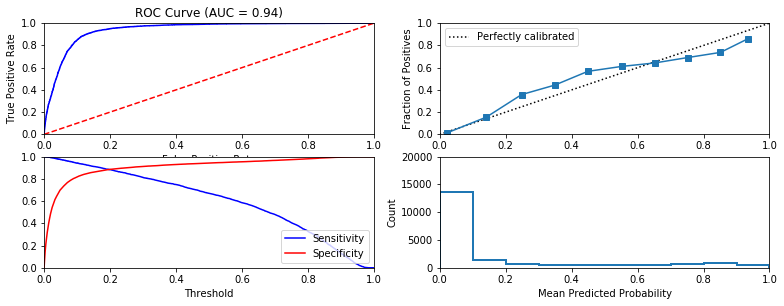


Similarity to LC grade ranking:  0.32658249433943665
Brier score: 0.07365337457141326
Were parameters on edge? : False
Score variations around CV search grid : 8.373214616954176
[0.82326667 0.82326667 0.82326667 0.8884     0.89593333 0.8982
 0.89846667 0.8985     0.8985     0.8985    ]


In [14]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'random', "l1 Logistic Regression")

### $l_2$ regularized logistic regression

              Model: l2 Logistic Regression
Fit time: 3.75 seconds
Optimal parameters:
{'C': 1000.0}

Accuracy-maximizing threshold was: 0.4164322782780064
Accuracy:  0.90525
              precision    recall  f1-score   support

  No default     0.9516    0.9315    0.9415     16362
     Default     0.7188    0.7870    0.7513      3638

   micro avg     0.9052    0.9052    0.9052     20000
   macro avg     0.8352    0.8593    0.8464     20000
weighted avg     0.9093    0.9052    0.9069     20000



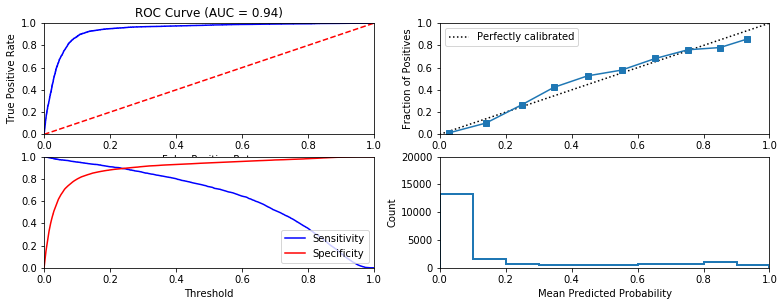


Similarity to LC grade ranking:  0.0039136492034288605
Brier score: 0.06861158071528954
Were parameters on edge? : False
Score variations around CV search grid : 7.702976235100083
[0.82076667 0.82076667 0.82076667 0.87193333 0.88816667 0.88916667
 0.88913333 0.88923333 0.88926667 0.88926667]


In [52]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'random', "l2 Logistic Regression")

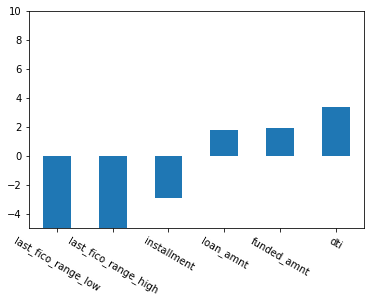

In [11]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

                Model: Decision Tree
Fit time: 10.41 seconds
Optimal parameters:
{'max_depth': 3.0}

Accuracy-maximizing threshold was: 0.5404040404040404
Accuracy:  0.88785
              precision    recall  f1-score   support

  No default     0.9274    0.9362    0.9318     16367
     Default     0.6998    0.6700    0.6846      3633

   micro avg     0.8879    0.8879    0.8878     20000
   macro avg     0.8136    0.8031    0.8082     20000
weighted avg     0.8861    0.8879    0.8869     20000



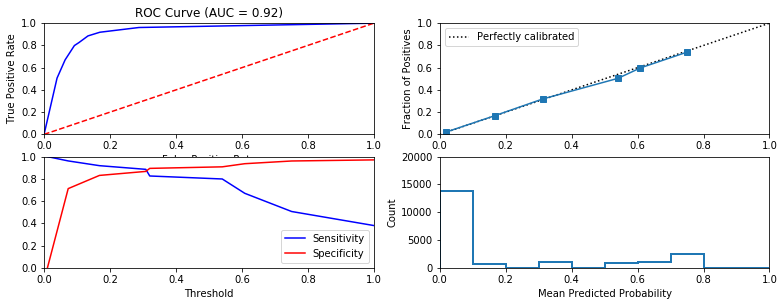


Similarity to LC grade ranking:  0.2649735119040692
Brier score: 0.07737524900635677
Were parameters on edge? : False
Score variations around CV search grid : 4.343600478468907
[0.88156667 0.8865     0.89173333 0.88786667 0.8912     0.89106667
 0.88796667 0.88423333 0.88206667 0.87646667 0.8739     0.871
 0.8679     0.8641     0.85923333 0.8559     0.85533333 0.8559
 0.853      0.853     ]


In [12]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':np.linspace(1, 20, 20)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'random', "Decision Tree")

### Random forest

                Model: Random Forest
Fit time: 277.11 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 150}

Accuracy-maximizing threshold was: 0.5725874537619475
Accuracy:  0.8915
              precision    recall  f1-score   support

  No default     0.9285    0.9398    0.9341     16367
     Default     0.7131    0.6738    0.6929      3633

   micro avg     0.8915    0.8915    0.8915     20000
   macro avg     0.8208    0.8068    0.8135     20000
weighted avg     0.8893    0.8915    0.8903     20000



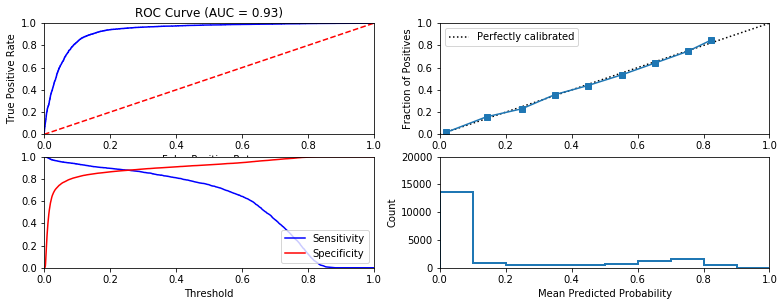


Similarity to LC grade ranking:  0.3803024084744011
Brier score: 0.07443455122188206
Were parameters on edge? : False
Score variations around CV search grid : 0.464787684985497
[0.89563333 0.8956     0.8953     0.89556667 0.89553333 0.8952
 0.89603333 0.89626667 0.89576667 0.89603333 0.8952     0.8963
 0.89613333 0.896      0.89613333 0.89396667 0.89583333 0.89603333
 0.8959     0.896      0.89436667 0.89493333 0.8954     0.89646667
 0.89593333 0.8923     0.89556667 0.89513333 0.89553333 0.8963    ]


In [13]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[20,50,100,150,200],'max_depth':np.arange(6,12)}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'random', "Random Forest")

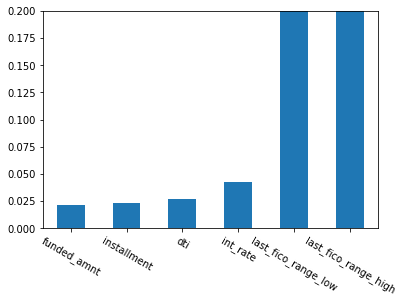

In [14]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

                Model: Multi-layer Perceptron
Fit time: 134.19 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0016}

Accuracy-maximizing threshold was: 0.514928887227988
Accuracy:  0.8932
              precision    recall  f1-score   support

  No default     0.9409    0.9277    0.9343     16367
     Default     0.6938    0.7377    0.7150      3633

   micro avg     0.8932    0.8932    0.8932     20000
   macro avg     0.8174    0.8327    0.8247     20000
weighted avg     0.8960    0.8932    0.8945     20000



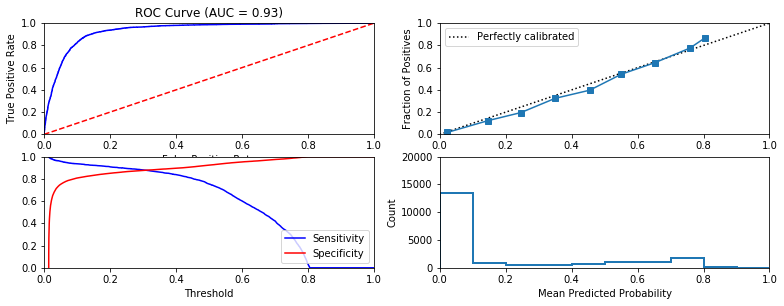


Similarity to LC grade ranking:  0.2856334395746198
Brier score: 0.07499702195966873
Were parameters on edge? : True
Score variations around CV search grid : 4.015780267222442
[0.8878     0.85966667 0.88303333 0.8919     0.88783333 0.89236667
 0.8789     0.8782     0.87353333 0.89416667 0.8684     0.86116667
 0.86503333 0.8932     0.89496667 0.86556667 0.89383333 0.86306667
 0.88993333 0.8895     0.8888     0.8786     0.89523333 0.86506667
 0.86506667 0.88663333 0.864      0.89563333 0.88156667 0.88783333
 0.89453333 0.86386667 0.8689     0.8866     0.89413333 0.88663333]


In [15]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(learning_rate_init=0.1)
cv_parameters = {'activation':['identity','relu','logistic'],'alpha':([[5],[10]]**np.arange(-7.,-1)).ravel()}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'random', "Multi-layer Perceptron")

### Bagging

              Model: Bagging
Fit time: 30.2 seconds
Optimal parameters:
{'max_features': 13}

Accuracy-maximizing threshold was: 0.5
Accuracy:  0.881
              precision    recall  f1-score   support

  No default     0.9194    0.9368    0.9280     16367
     Default     0.6885    0.6298    0.6578      3633

   micro avg     0.8810    0.8810    0.8810     20000
   macro avg     0.8039    0.7833    0.7929     20000
weighted avg     0.8774    0.8810    0.8789     20000



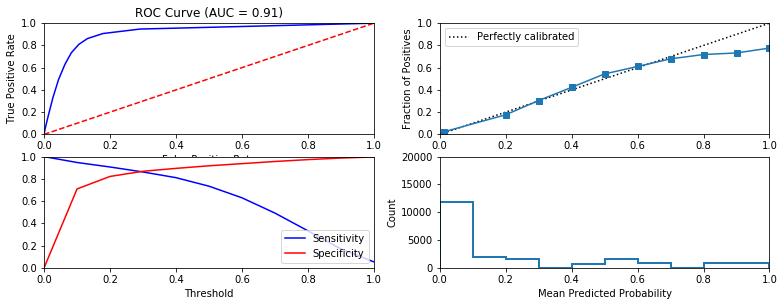


Similarity to LC grade ranking:  0.2478350272753914
Brier score: 0.08336600000000001
Were parameters on edge? : False
Score variations around CV search grid : 1.4332715652535577
[0.87326667 0.87466667 0.87823333 0.8688     0.87753333 0.88043333
 0.8798     0.88143333 0.87803333]


In [16]:
bag = BaggingClassifier()
cv_parameters = {'max_features':np.arange(6,15)}

random_forest = fit_classification(bag, data_dict, cv_parameters, 'random', "Bagging")

### Gradient Boosting

                Model: Gradient Boosting
Fit time: 107.36 seconds
Optimal parameters:
{'max_depth': 4, 'n_estimators': 20}

Accuracy-maximizing threshold was: 0.4730288760534636
Accuracy:  0.8938
              precision    recall  f1-score   support

  No default     0.9410    0.9284    0.9347     16367
     Default     0.6958    0.7380    0.7163      3633

   micro avg     0.8938    0.8938    0.8938     20000
   macro avg     0.8184    0.8332    0.8255     20000
weighted avg     0.8965    0.8938    0.8950     20000



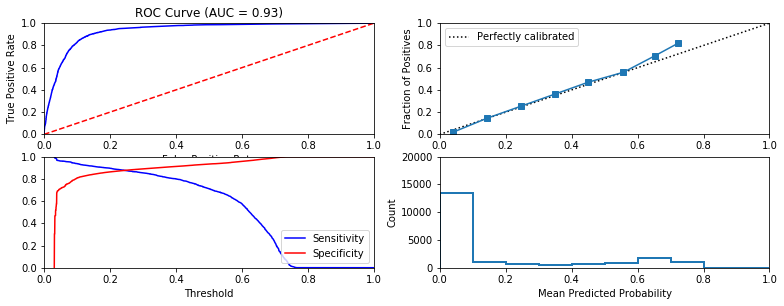


Similarity to LC grade ranking:  0.2768733492370417
Brier score: 0.07579975328275257
Were parameters on edge? : True
Score variations around CV search grid : 0.46522014217127383
[0.8947     0.89496667 0.89533333 0.89463333 0.89563333 0.89536667
 0.8946     0.89353333 0.8951     0.8941     0.8939     0.8924
 0.89433333 0.89373333 0.89266667 0.89146667]


In [17]:
gb = GradientBoostingClassifier()
cv_parameters = {'n_estimators':[20,50,100,150],'max_depth':np.arange(3,7)}

gb = fit_classification(gb, data_dict, cv_parameters, 'random', "Gradient Boosting")

## Q2. Train and Test different machine learning classification models (Temporal train/test split)

In [16]:
# 2.2 Temporal training/test split
# find the cut-off date (70%/30%)
data.sort_values(by="issue_d",inplace=True)
data.reset_index(drop=True,inplace=True)
data['issue_d'][int(len(data)*0.7)]
print(len(data[data['issue_d']>datetime.date(2015, 11, 1)])/len(data))
print(len(data[data['issue_d']>datetime.date(2015, 10, 1)])/len(data))
data['train'] = [False]*len(data)
data['train'][data['issue_d']<=datetime.date(2015, 10, 1)]=True

train = data.train.values

0.28767964478454433
0.30862133933661196


In [17]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

              Model: Naive Bayes
Fit time: 0.4 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.90087465337703
Accuracy:  0.89885
              precision    recall  f1-score   support

  No default     0.9410    0.9350    0.9380     16362
     Default     0.7159    0.7361    0.7258      3638

   micro avg     0.8989    0.8989    0.8989     20000
   macro avg     0.8284    0.8356    0.8319     20000
weighted avg     0.9000    0.8989    0.8994     20000



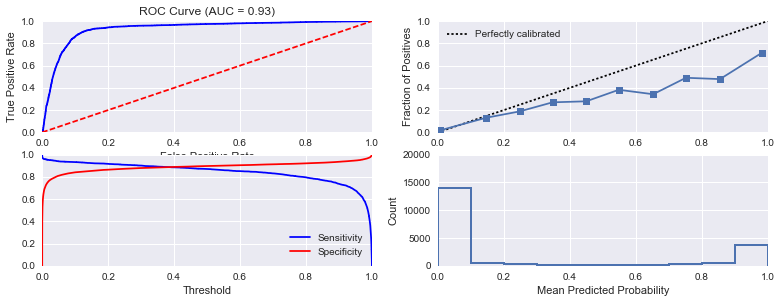


Similarity to LC grade ranking:  0.003690924912025519
Brier score: 0.09107453224506591
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.87783333]


In [36]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, {}, 'time', "Naive Bayes")

### $l_1$ regularized logistic regression

                Model: l1 Logistic Regression
Fit time: 24.04 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.41665925622602856
Accuracy:  0.90525
              precision    recall  f1-score   support

  No default     0.9516    0.9316    0.9415     16362
     Default     0.7189    0.7867    0.7513      3638

   micro avg     0.9052    0.9052    0.9052     20000
   macro avg     0.8352    0.8592    0.8464     20000
weighted avg     0.9092    0.9052    0.9069     20000



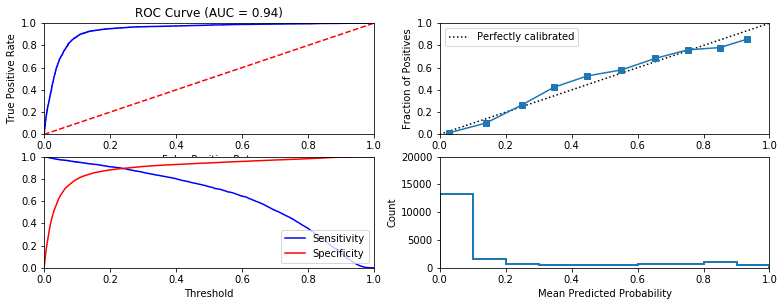


Similarity to LC grade ranking:  0.0038533462558435426
Brier score: 0.06860646160078955
Were parameters on edge? : False
Score variations around CV search grid : 7.765208270902014
[0.82076667 0.82076667 0.82076667 0.88136667 0.8887     0.8895
 0.88983333 0.88986667 0.88983333 0.88983333]


In [21]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'time', "l1 Logistic Regression")

### $l_2$ regularized logistic regression

              Model: l2 Logistic Regression
Fit time: 10.09 seconds
Optimal parameters:
{'C': 10.0}

Accuracy-maximizing threshold was: 0.4195568182501841
Accuracy:  0.90535
              precision    recall  f1-score   support

  No default     0.9515    0.9319    0.9416     16362
     Default     0.7195    0.7861    0.7513      3638

   micro avg     0.9053    0.9053    0.9053     20000
   macro avg     0.8355    0.8590    0.8464     20000
weighted avg     0.9093    0.9053    0.9070     20000



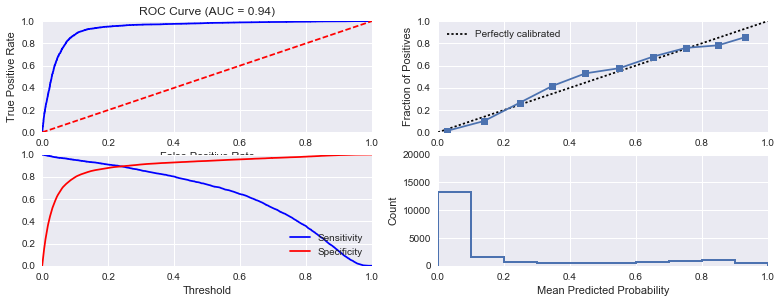


Similarity to LC grade ranking:  0.0038895955540201427
Brier score: 0.0686064718395458
Were parameters on edge? : False
Score variations around CV search grid : 7.758297744811575
[0.82076667 0.82076667 0.82076667 0.87536667 0.88883333 0.88963333
 0.8898     0.88973333 0.88973333 0.8898    ]


In [37]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'time', "l2 Logistic Regression")

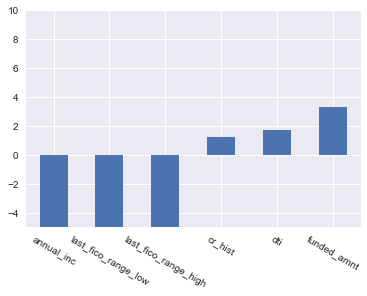

In [20]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

                Model: Decision Tree
Fit time: 16.29 seconds
Optimal parameters:
{'max_depth': 5.0}

Accuracy-maximizing threshold was: 0.5114942528735632
Accuracy:  0.9039
              precision    recall  f1-score   support

  No default     0.9479    0.9338    0.9408     16362
     Default     0.7210    0.7694    0.7444      3638

   micro avg     0.9039    0.9039    0.9039     20000
   macro avg     0.8345    0.8516    0.8426     20000
weighted avg     0.9067    0.9039    0.9051     20000



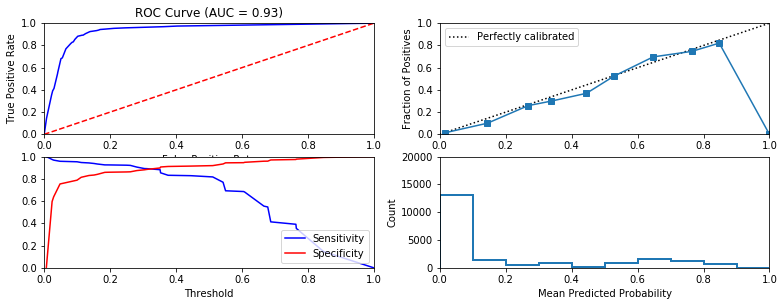


Similarity to LC grade ranking:  0.004760346910645591
Brier score: 0.0711594000409473
Were parameters on edge? : False
Score variations around CV search grid : 4.263376954516485
[0.86746667 0.8849     0.88496667 0.88606667 0.88896667 0.8864
 0.8846     0.8828     0.87973333 0.87633333 0.87113333 0.86846667
 0.86353333 0.86263333 0.8595     0.85753333 0.85483333 0.8539
 0.85153333 0.85106667]


In [24]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':np.linspace(1, 20, 20)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'time', "Decision Tree")

### Random forest

                Model: Random Forest
Fit time: 399.4 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 150}

Accuracy-maximizing threshold was: 0.500364626366525
Accuracy:  0.90565
              precision    recall  f1-score   support

  No default     0.9506    0.9332    0.9418     16362
     Default     0.7224    0.7817    0.7509      3638

   micro avg     0.9056    0.9056    0.9056     20000
   macro avg     0.8365    0.8575    0.8463     20000
weighted avg     0.9091    0.9056    0.9071     20000



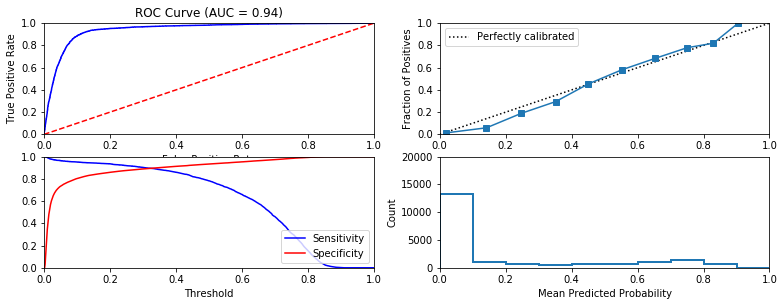


Similarity to LC grade ranking:  0.0034234244391542993
Brier score: 0.06805515475598038
Were parameters on edge? : False
Score variations around CV search grid : 0.2951726199372339
[0.8895     0.89166667 0.89173333 0.8909     0.89163333 0.89146667
 0.89106667 0.89166667 0.89133333 0.89156667 0.89103333 0.89123333
 0.892      0.891      0.8911     0.8898     0.8913     0.8914
 0.89196667 0.8917     0.88973333 0.89073333 0.8919     0.89213333
 0.89156667 0.89033333 0.89093333 0.89033333 0.8913     0.8913    ]


In [25]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[20,50,100,150,200],'max_depth':np.arange(6,12)}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'time', "Random Forest")

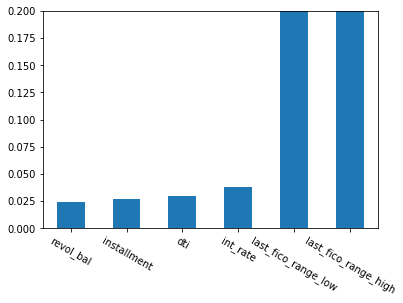

In [26]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

                Model: Multi-layer Perceptron
Fit time: 771.29 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 1.28e-05}

Accuracy-maximizing threshold was: 0.489289456130661
Accuracy:  0.90585
              precision    recall  f1-score   support

  No default     0.9526    0.9313    0.9418     16362
     Default     0.7192    0.7914    0.7536      3638

   micro avg     0.9059    0.9059    0.9059     20000
   macro avg     0.8359    0.8613    0.8477     20000
weighted avg     0.9101    0.9059    0.9076     20000



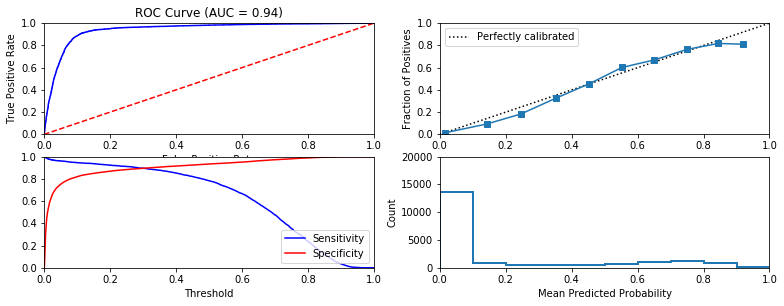


Similarity to LC grade ranking:  0.002704586695249087
Brier score: 0.06799170553037857
Were parameters on edge? : True
Score variations around CV search grid : 0.7090081349354395
[0.891      0.88973333 0.8903     0.8896     0.89026667 0.89006667
 0.88866667 0.89043333 0.88693333 0.8901     0.89066667 0.88953333
 0.89096667 0.89323333 0.89266667 0.8915     0.8927     0.89153333
 0.89213333 0.8926     0.8919     0.89266667 0.8918     0.89196667
 0.89326667 0.8916     0.8915     0.89193333 0.89       0.8901
 0.89293333 0.89293333 0.8926     0.8929     0.89293333 0.89103333]


In [27]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(learning_rate_init=0.1)
cv_parameters = {'activation':['identity','relu','logistic'],'alpha':([[5],[10]]**np.arange(-7.,-1)).ravel()}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'time', "Multi-layer Perceptron")

### Bagging

                Model: Bagging
Fit time: 35.86 seconds
Optimal parameters:
{'max_features': 11}

Accuracy-maximizing threshold was: 0.5
Accuracy:  0.8872
              precision    recall  f1-score   support

  No default     0.9239    0.9396    0.9316     16362
     Default     0.7057    0.6517    0.6776      3638

   micro avg     0.8872    0.8872    0.8872     20000
   macro avg     0.8148    0.7956    0.8046     20000
weighted avg     0.8842    0.8872    0.8854     20000



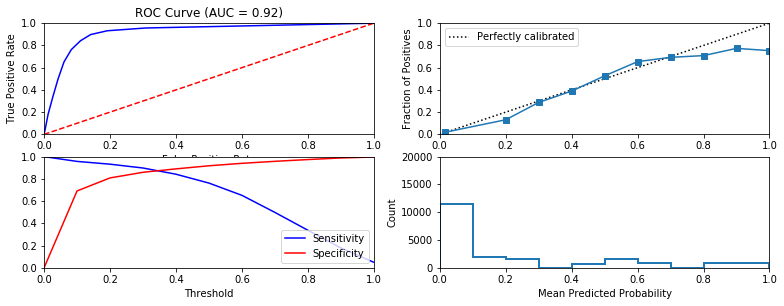


Similarity to LC grade ranking:  -0.0021455223178032516
Brier score: 0.080069
Were parameters on edge? : True
Score variations around CV search grid : 1.033356127953803
[0.86926667 0.86833333 0.8684     0.86993333 0.87223333 0.8774    ]


In [28]:
bag = BaggingClassifier()
cv_parameters = {'max_features':np.arange(6,15)}

random_forest = fit_classification(bag, data_dict, cv_parameters, 'time', "Bagging")

### Gradient Boosting

                Model: Gradient Boosting
Fit time: 243.01 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 150}

Accuracy-maximizing threshold was: 0.523410736098096
Accuracy:  0.90185
              precision    recall  f1-score   support

  No default     0.9413    0.9385    0.9399     16362
     Default     0.7271    0.7369    0.7320      3638

   micro avg     0.9019    0.9019    0.9019     20000
   macro avg     0.8342    0.8377    0.8360     20000
weighted avg     0.9024    0.9019    0.9021     20000



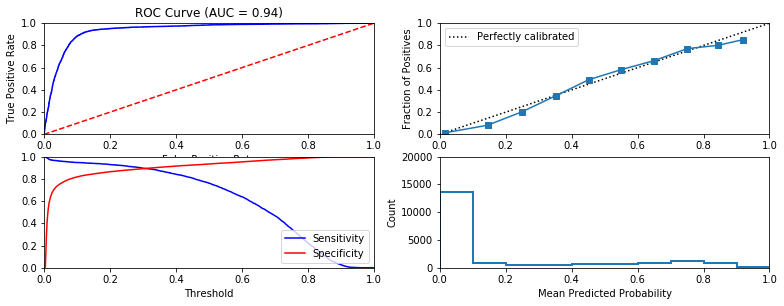


Similarity to LC grade ranking:  0.0055298244135071044
Brier score: 0.0691452941180076
Were parameters on edge? : True
Score variations around CV search grid : 0.5786604942880593
[0.8898     0.8914     0.89213333 0.89286667 0.8908     0.89236667
 0.89173333 0.89166667 0.8909     0.8922     0.89056667 0.88956667
 0.88943333 0.89023333 0.88976667 0.8877    ]


In [29]:
gb = GradientBoostingClassifier()
cv_parameters = {'n_estimators':[20,50,100,150],'max_depth':np.arange(3,7)}

gb = fit_classification(gb, data_dict, cv_parameters, 'time', "Gradient Boosting")

## Q3.1 List of features derived by LendingClub

In [30]:
print(['grade','dti'])

['grade', 'dti']


## Q3.2 Train and Test logistic regression model with features derived by LendingClub

                Model: l1 Logistic Regression - dti
Fit time: 1.71 seconds
Optimal parameters:
{'C': 1e-10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8181
              precision    recall  f1-score   support

  No default     0.8181    1.0000    0.9000     16362
     Default     0.0000    0.0000    0.0000      3638

   micro avg     0.8181    0.8181    0.8181     20000
   macro avg     0.4091    0.5000    0.4500     20000
weighted avg     0.6693    0.8181    0.7362     20000



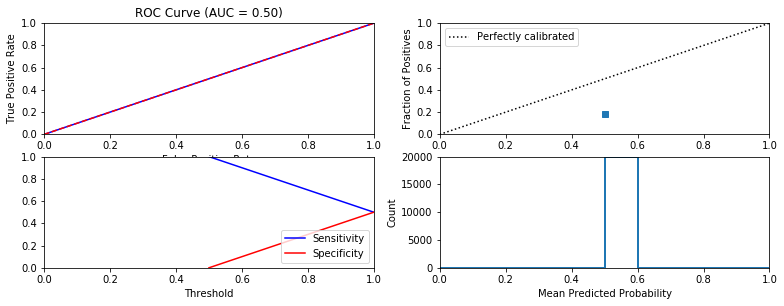


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : True
Score variations around CV search grid : 0.004061243552775413
[0.82076667 0.82076667 0.82076667 0.82076667 0.82076667 0.82076667
 0.82076667 0.82076667 0.82076667 0.82073333 0.82073333 0.82073333
 0.82073333 0.82073333 0.82073333]


In [31]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'dti'
data_dict = prepare_data(feature_subset = a_lendingclub_feature)

cv_parameters = {'C':10**np.arange(-10., 5.)}
lc1_only_logistic = LogisticRegression(penalty='l1')

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, 'time', "l1 Logistic Regression - dti")

                Model: l2 Logistic Regression - dti
Fit time: 0.85 seconds
Optimal parameters:
{'C': 1e-05}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8181
              precision    recall  f1-score   support

  No default     0.8181    1.0000    0.9000     16362
     Default     0.0000    0.0000    0.0000      3638

   micro avg     0.8181    0.8181    0.8181     20000
   macro avg     0.4091    0.5000    0.4500     20000
weighted avg     0.6693    0.8181    0.7362     20000



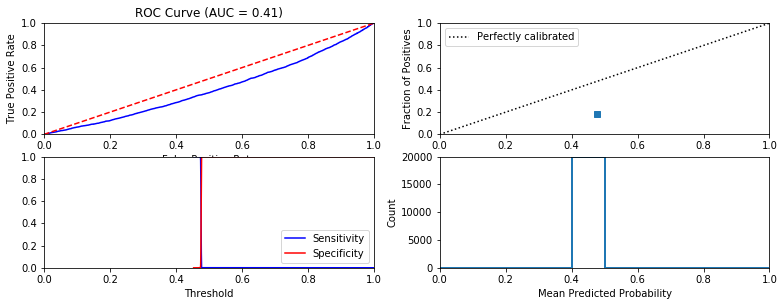


Similarity to LC grade ranking:  -0.006792109977701097
Brier score: 0.23551875927403784
Were parameters on edge? : True
Score variations around CV search grid : 0.004061243552775413
[0.82076667 0.82076667 0.82076667 0.82076667 0.82076667 0.82073333
 0.82073333 0.82073333 0.82073333 0.82073333]


In [32]:
## train a l2-regularized logistic regression model on data with only that feature
cv_parameters = {'C':10**np.arange(-5., 5.)}
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, 'time', "l2 Logistic Regression - dti")

## Q3.3 Train and test all the models you have tried previously after removing features derived by LendingClub 

In [33]:
## define your set of features to use in different models
grade_dummies = [v for v in discrete_features_dummies if v.split("::")[0] == 'grade']
your_features = list(set(continuous_features+discrete_features_dummies)-set(grade_dummies)-set(['dti']))

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

                Average Performance Report
Running time for 100 models: 00 hours 01 min 12 sec
Average accuracy-maximizing threshold: (0.93986, 0.17070)
Average accuracy: (0.85702, 0.00364)

                Model: Naive Bayes
Fit time: 0.22 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999995414455952
Accuracy:  0.8643
              precision    recall  f1-score   support

  No default     0.9241    0.9088    0.9164     16362
     Default     0.6182    0.6641    0.6403      3638

   micro avg     0.8643    0.8643    0.8643     20000
   macro avg     0.7711    0.7865    0.7784     20000
weighted avg     0.8684    0.8643    0.8662     20000



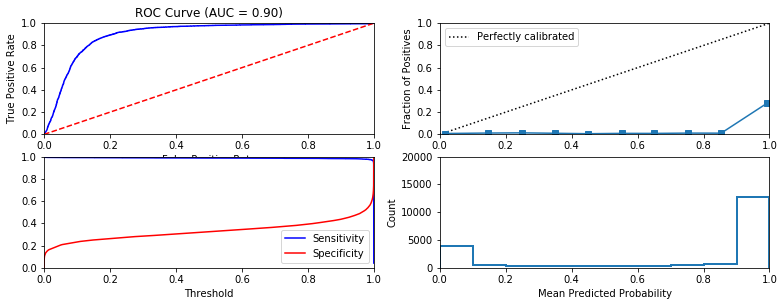


Similarity to LC grade ranking:  0.0014477527808124664
Brier score: 0.5117739795650974
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.55226667]


In [34]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, {}, 'random', "Naive Bayes", avg_100=True)

### $l_1$ regularized logistic regression

                Average Performance Report
Running time for 100 models: 00 hours 36 min 02 sec
Average accuracy-maximizing threshold: (0.39181, 0.03014)
Average accuracy: (0.89607, 0.00240)

                Model: l1 Logistic Regression
Fit time: 16.61 seconds
Optimal parameters:
{'C': 10000.0}

Accuracy-maximizing threshold was: 0.39706624360605636
Accuracy:  0.8934
              precision    recall  f1-score   support

  No default     0.9414    0.9275    0.9344     16362
     Default     0.6941    0.7402    0.7164      3638

   micro avg     0.8934    0.8934    0.8934     20000
   macro avg     0.8177    0.8338    0.8254     20000
weighted avg     0.8964    0.8934    0.8947     20000



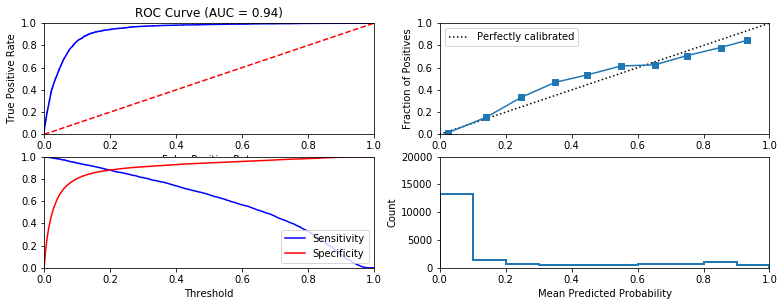


Similarity to LC grade ranking:  0.002711158378777606
Brier score: 0.07543044228760577
Were parameters on edge? : True
Score variations around CV search grid : 8.224411070746418
[0.81683333 0.81683333 0.81683333 0.8813     0.88756667 0.89
 0.88983333 0.88996667 0.88996667 0.89003333]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'random', "l1 Logistic Regression", avg_100=True)

### $l_2$ regularized logistic regression

                Average Performance Report
Running time for 100 models: 00 hours 07 min 57 sec
Average accuracy-maximizing threshold: (0.39253, 0.02689)
Average accuracy: (0.89612, 0.00242)

                Model: l2 Logistic Regression
Fit time: 5.78 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.39860306459951367
Accuracy:  0.89315
              precision    recall  f1-score   support

  No default     0.9408    0.9278    0.9342     16362
     Default     0.6943    0.7372    0.7151      3638

   micro avg     0.8931    0.8931    0.8931     20000
   macro avg     0.8175    0.8325    0.8247     20000
weighted avg     0.8959    0.8931    0.8944     20000



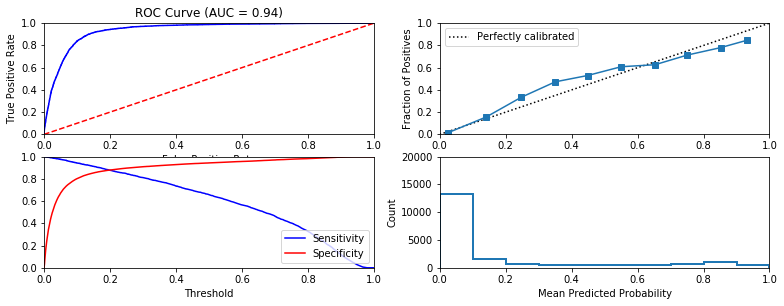


Similarity to LC grade ranking:  0.0028126569967876
Brier score: 0.0754428173315459
Were parameters on edge? : False
Score variations around CV search grid : 8.21066037382478
[0.81683333 0.81683333 0.81686667 0.87516667 0.88833333 0.88983333
 0.8898     0.8899     0.88983333 0.88986667]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'random', "l2 Logistic Regression", avg_100=True)

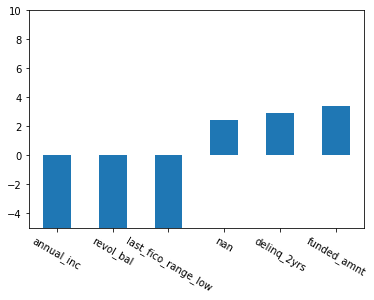

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

                Average Performance Report
Running time for 100 models: 00 hours 18 min 53 sec
Average accuracy-maximizing threshold: (0.57526, 0.05453)
Average accuracy: (0.88531, 0.00963)

                Model: Decision Tree
Fit time: 10.56 seconds
Optimal parameters:
{'max_depth': 4.0}

Accuracy-maximizing threshold was: 0.519163763066202
Accuracy:  0.88705
              precision    recall  f1-score   support

  No default     0.9185    0.9459    0.9320     16362
     Default     0.7190    0.6223    0.6672      3638

   micro avg     0.8871    0.8871    0.8871     20000
   macro avg     0.8187    0.7841    0.7996     20000
weighted avg     0.8822    0.8871    0.8838     20000



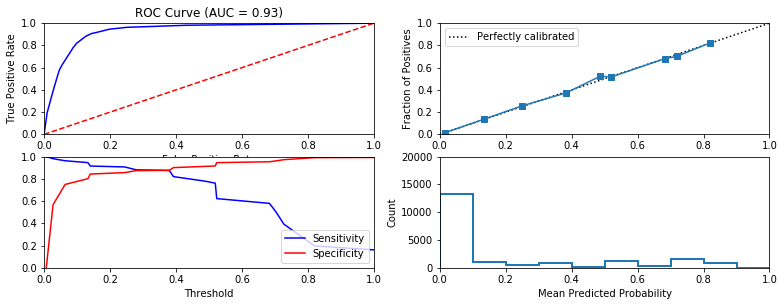


Similarity to LC grade ranking:  0.0009515620271378549
Brier score: 0.07581810833788573
Were parameters on edge? : False
Score variations around CV search grid : 4.570527974783291
[0.88233333 0.8833     0.88223333 0.8883     0.88416667 0.88483333
 0.8803     0.8785     0.87406667 0.8734     0.8689     0.86313333
 0.8603     0.8566     0.8531     0.85343333 0.85213333 0.84943333
 0.84893333 0.8477    ]


In [ ]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':np.linspace(1, 20, 20)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'random', "Decision Tree", avg_100=True)

### Random forest

                Average Performance Report
Running time for 100 models: 05 hours 29 min 25 sec
Average accuracy-maximizing threshold: (0.54688, 0.01609)
Average accuracy: (0.89419, 0.00234)

                Model: Random Forest
Fit time: 177.32 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.5166083628178654
Accuracy:  0.89425
              precision    recall  f1-score   support

  No default     0.9339    0.9371    0.9355     16362
     Default     0.7127    0.7015    0.7070      3638

   micro avg     0.8942    0.8942    0.8942     20000
   macro avg     0.8233    0.8193    0.8213     20000
weighted avg     0.8936    0.8942    0.8939     20000



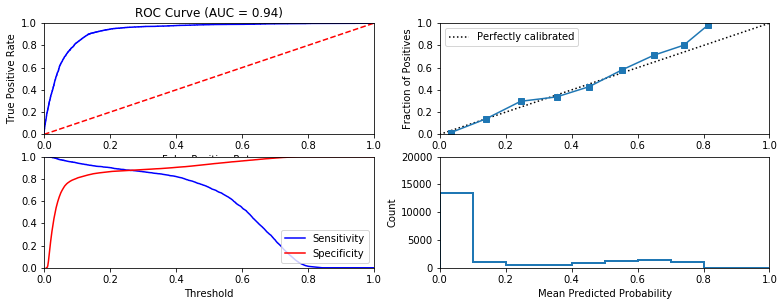


Similarity to LC grade ranking:  0.0016964542372132926
Brier score: 0.0750057035796022
Were parameters on edge? : False
Score variations around CV search grid : 1.8436963499290844
[0.87666667 0.88696667 0.8881     0.8866     0.8863     0.88823333
 0.8884     0.8893     0.89026667 0.89036667 0.88933333 0.8906
 0.89056667 0.89083333 0.89126667 0.8862     0.8916     0.89083333
 0.89183333 0.89133333 0.88903333 0.89036667 0.89313333 0.89103333
 0.89096667 0.88826667 0.8908     0.89143333 0.8917     0.8923    ]


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[20,50,100,150,200],'max_depth':np.arange(6,12)}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'random', "Random Forest", avg_100=True)

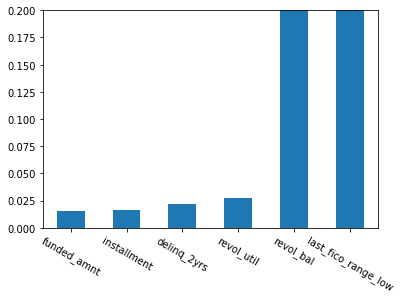

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

              Average Performance Report
Running time for 100 models: 04 hours 31 min 16 sec
Average accuracy-maximizing threshold: (0.58916, 0.24353)
Average accuracy: (0.87947, 0.02674)

              Model: Multi-layer Perceptron
Fit time: 164.95 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.00032}

Accuracy-maximizing threshold was: 0.7007592547798995
Accuracy:  0.89005
              precision    recall  f1-score   support

  No default     0.9487    0.9151    0.9316     16362
     Default     0.6706    0.7774    0.7201      3638

   micro avg     0.8901    0.8901    0.8901     20000
   macro avg     0.8096    0.8462    0.8258     20000
weighted avg     0.8981    0.8901    0.8931     20000



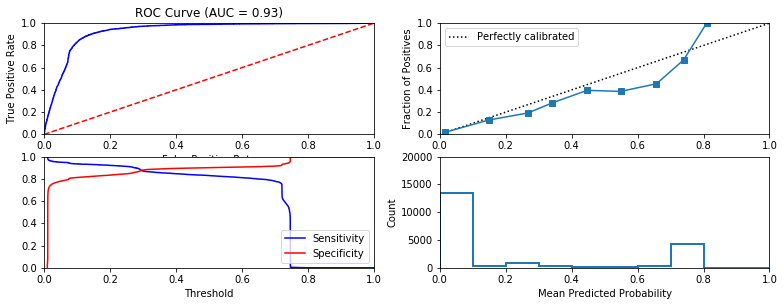


Similarity to LC grade ranking:  0.21449491795068754
Brier score: 0.0799470628627037
Were parameters on edge? : True
Score variations around CV search grid : 27.92907854701176
[0.87243333 0.83963333 0.6778     0.87923333 0.8704     0.86933333
 0.79813333 0.73823333 0.8162     0.85226667 0.88046667 0.63953333
 0.83203333 0.81683333 0.81683333 0.8602     0.8576     0.8319
 0.84236667 0.84506667 0.81683333 0.8314     0.85726667 0.8326
 0.88113333 0.88693333 0.88736667 0.8846     0.85863333 0.8825
 0.87796667 0.64976667 0.8589     0.88093333 0.85733333 0.85736667]


In [41]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(learning_rate_init=0.5)
cv_parameters = {'activation':['identity','relu','logistic'],'alpha':([[5],[10]]**np.arange(-7.,-1)).ravel()}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'random', "Multi-layer Perceptron", avg_100=True)

### Bagging

              Average Performance Report
Running time for 100 models: 00 hours 21 min 53 sec
Average accuracy-maximizing threshold: (0.40619, 0.01540)
Average accuracy: (0.83684, 0.00379)

              Model: Bagging
Fit time: 11.09 seconds
Optimal parameters:
{'max_features': 10}

Accuracy-maximizing threshold was: 0.32544130940098176
Accuracy:  0.8207
              precision    recall  f1-score   support

  No default     0.8629    0.9283    0.8944     16362
     Default     0.5108    0.3367    0.4059      3638

   micro avg     0.8207    0.8207    0.8207     20000
   macro avg     0.6869    0.6325    0.6502     20000
weighted avg     0.7989    0.8207    0.8056     20000



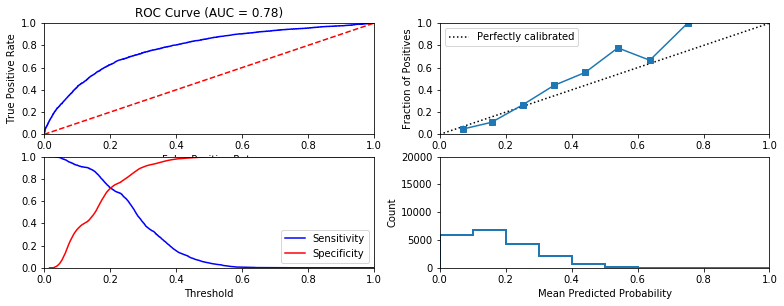


Similarity to LC grade ranking:  0.21585576006518464
Brier score: 0.12643580647401845
Were parameters on edge? : False
Score variations around CV search grid : 3.624926282681338
[0.8171     0.8276     0.82356667 0.82503333 0.84783333 0.84733333
 0.81956667 0.83866667 0.83966667]


In [42]:
bag = BaggingClassifier()
cv_parameters = {'max_features':np.arange(6,15)}

random_forest = fit_classification(bag, data_dict, cv_parameters, 'random', "Bagging", avg_100=True)

### Gradient Boosting

              Average Performance Report
Running time for 100 models: 07 hours 51 min 35 sec
Average accuracy-maximizing threshold: (0.51518, 0.02319)
Average accuracy: (0.89594, 0.00240)

              Model: Gradient Boosting
Fit time: 248.24 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.48064707567009946
Accuracy:  0.8935
              precision    recall  f1-score   support

  No default     0.9436    0.9251    0.9343     16362
     Default     0.6905    0.7512    0.7196      3638

   micro avg     0.8935    0.8935    0.8935     20000
   macro avg     0.8170    0.8382    0.8269     20000
weighted avg     0.8975    0.8935    0.8952     20000



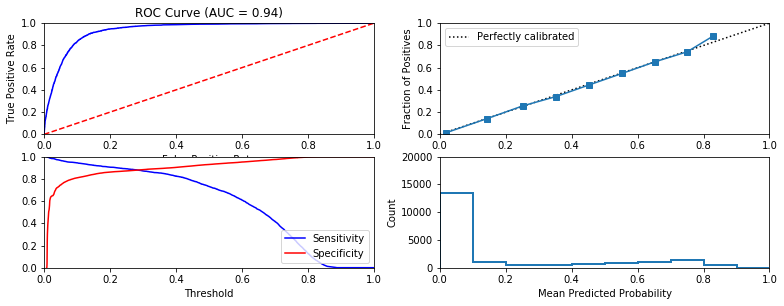


Similarity to LC grade ranking:  0.26805103322786744
Brier score: 0.07358806479381137
Were parameters on edge? : True
Score variations around CV search grid : 0.4824955116696556
[0.88913333 0.8912     0.89076667 0.89026667 0.88896667 0.89083333
 0.88943333 0.89016667 0.88873333 0.8894     0.88836667 0.88773333
 0.88813333 0.88863333 0.8869     0.88736667]


In [43]:
gb = GradientBoostingClassifier()
cv_parameters = {'n_estimators':[20,50,100,150],'max_depth':np.arange(3,7)}

gb = fit_classification(gb, data_dict, cv_parameters, 'random', "Gradient Boosting", avg_100=True)

## Q4. Estimations of YOURMODEL v.s. Grades

In [50]:
## define your set of features to use in different models
grade_dummies = [v for v in discrete_features_dummies if v.split("::")[0] == 'grade']
your_features = list(set(continuous_features+discrete_features_dummies)-set(grade_dummies)-set(['dti']))

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

              Model: l2 Logistic Regression
Fit time: 1.67 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.4158526533215616
Accuracy:  0.8936
              precision    recall  f1-score   support

  No default     0.9393    0.9301    0.9347     16367
     Default     0.6984    0.7291    0.7134      3633

   micro avg     0.8936    0.8936    0.8936     20000
   macro avg     0.8188    0.8296    0.8241     20000
weighted avg     0.8955    0.8936    0.8945     20000



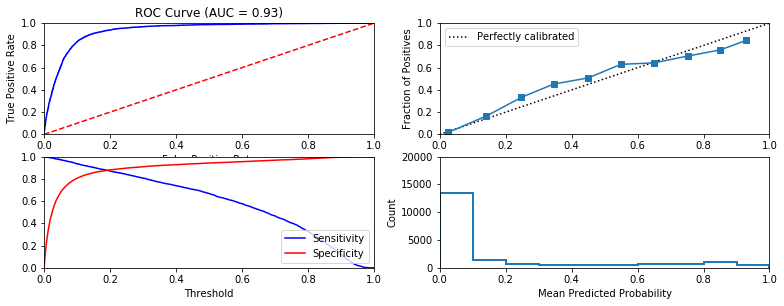


Similarity to LC grade ranking:  0.326681265532413
Brier score: 0.07636016233745624
Were parameters on edge? : False
Score variations around CV search grid : 8.319647656016725
[0.81876667 0.81876667 0.81876667 0.87636667 0.8905     0.89253333
 0.8927     0.89306667 0.893      0.89296667]


In [8]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'random', "l2 Logistic Regression")

In [9]:
# my_model=l2_logistic

# grades='GFEDCBA'
# pred_sort_idx=np.argsort(my_model['y_pred_probs'])
# pred_grade=np.zeros(len(pred_sort_idx),dtype=str)

# for i in range(len(grades)):
#     for j in range(len(pred_sort_idx)//len(grades)*i,len(pred_sort_idx)//len(grades)*(i+1)):
#         pred_grade[pred_sort_idx[j]]=grades[i]
# pred_grade[-1]=grades[-1]

# print('The percentage of agreements between best model scores and LC grades is {}.'.format
#       (sum(pred_grade==data[data_dict['test_set']].grade.values)/len(pred_sort_idx)))

The percentage of agreements between best model scores and LC grades is 0.11595.


## Q5. Time stability test of YOURMODEL

              Model: Time Stability - 2010
Fit time: 2.12 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.4158526533215616
Accuracy:  0.8936
              precision    recall  f1-score   support

  No default     0.9393    0.9301    0.9347     16367
     Default     0.6984    0.7291    0.7134      3633

   micro avg     0.8936    0.8936    0.8936     20000
   macro avg     0.8188    0.8296    0.8241     20000
weighted avg     0.8955    0.8936    0.8945     20000



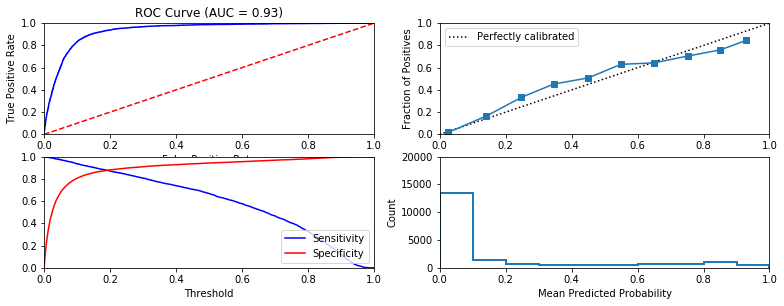


Similarity to LC grade ranking:  0.326681265532413
Brier score: 0.07636016233745624
Were parameters on edge? : False
Score variations around CV search grid : 8.319647656016725
[0.81876667 0.81876667 0.81876667 0.87636667 0.8905     0.89253333
 0.8927     0.89306667 0.893      0.89296667]


In [12]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 1)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
my_model = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

clf_2010 = fit_classification(my_model, data_dict, cv_parameters, "random", "Time Stability - 2010")

              Model: Time Stabiility - 2016
Fit time: 1.98 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.4158526533215616
Accuracy:  0.8936
              precision    recall  f1-score   support

  No default     0.9393    0.9301    0.9347     16367
     Default     0.6984    0.7291    0.7134      3633

   micro avg     0.8936    0.8936    0.8936     20000
   macro avg     0.8188    0.8296    0.8241     20000
weighted avg     0.8955    0.8936    0.8945     20000



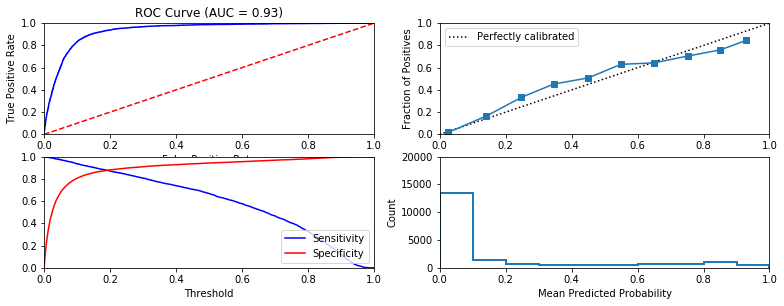


Similarity to LC grade ranking:  0.326681265532413
Brier score: 0.07636016233745624
Were parameters on edge? : False
Score variations around CV search grid : 8.319647656016725
[0.81876667 0.81876667 0.81876667 0.87636667 0.8905     0.89253333
 0.8927     0.89306667 0.893      0.89296667]


In [13]:
## Define the time window of your train and test data
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 1)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
my_model = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 5.)}

clf_2016 = fit_classification(my_model, data_dict, cv_parameters, "random", "Time Stabiility - 2016")

## Q6. Train and test YOURMODEL on the original data

### Load and preprocess the data

In [17]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False
    
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + directory + i)
        
        output[i] = pd.read_csv(directory + i , dtype="str", skiprows =1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([is_integer(x) for x in output[i]['id']]) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
        output[i] = output[i][invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [18]:
float_cols = ["loan_amnt","funded_amnt","funded_amnt_inv","installment","annual_inc",
              "dti","delinq_2yrs","open_acc","pub_rec","last_pymnt_amnt",
              "fico_range_high", "fico_range_low","last_fico_range_high", 
              "last_fico_range_low", "total_pymnt","recoveries","revol_bal"]
cat_cols = ["term","grade","sub_grade","emp_length","home_ownership","verification_status",
            "loan_status","purpose","zip_code","addr_state","application_type"] 
perc_cols = ["int_rate", "revol_util"]
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d"]

cols_to_pick=["id"]+float_cols+cat_cols+perc_cols+date_cols

discrete_features = list(set(cat_cols) - set(["loan_status"]))
continuous_features = list(float_cols+perc_cols)

files_cs = ingest_files("./data") 
data_cs = pd.concat(files_cs, axis=0, ignore_index=True)

# Keep only the columns of interest from 'data_cs'
data_original = data_cs[cols_to_pick]
print("\nStarting with " + str(len(data_original)) + " rows")

Directory ./data/ has 12 files:
    Reading file ./data/LoanStats_securev1_2016Q3.csv.zip
Found 99120 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q2.csv.zip
Found 97854 invalid rows which were removed
    Reading file ./data/LoanStats3a_securev1.csv.zip
Found 42535 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q1.csv.zip
Found 96779 invalid rows which were removed
    Reading file ./data/LoanStats3d_securev1.csv.zip
Found 421095 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q3.csv.zip
Found 122701 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q2.csv.zip
Found 105451 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q1.csv.zip
Found 133887 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q4.csv.zip
Found 103546 invalid rows which were removed
    Reading file ./data/LoanStats3c_securev1.csv.zip
Fo

In [19]:
# Typecast the columns
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%Y").date()

for i in float_cols:
    data_original[i] = data_original[i].astype('float') # typecast float columns

for i in perc_cols:
    data_original[i] = data_original[i].map(lambda x: clean_perc(x)) # apply clean_perc to percentage columns

for i in date_cols:
    data_original[i] = data_original[i].map(lambda x: clean_date(x)) # typecast date cloumns to datatime using clean_date
    
for i in cat_cols:
    data_original[i].loc[pd.isnull(data_original[i])] = None # for categorical features if the value is null/empty set it to None


    
# Deal with null values of all non-categorical variables
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(data_original)
# drop rows that contain null based only on "required_cols"
data_original = data_original.dropna(subset=required_cols)

print("Removed " + str(n_rows - len(data_original)) + " rows")



# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features.remove('total_pymnt')
continuous_features.remove('recoveries')

Removed 3564 rows


In [20]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS

data=data_original
data.reset_index(drop=True,inplace=True)

## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data['outcome'] = (data['loan_status']=='Charged Off')|(data['loan_status']=='Default')

# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Create a matrix of features and outcomes, with dummies. 
X_continuous = data[continuous_features].values
X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate((X_continuous, X_discrete), axis=1)
y = data.outcome.values

### Run the model (Random train/test split)

In [21]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS

# 2.1 Random train/test split
np.random.seed(default_seed)
data['train']=[False]*len(data)
data['train'][np.random.choice(len(data),int(len(data)*0.7),replace=False)]=True

train = data.train.values

## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

              Model: Original Data - Random
Fit time: 8.59 seconds
Optimal parameters:
{'C': 1000.0}

Accuracy-maximizing threshold was: 0.4150052246614619
Accuracy:  0.9424
              precision    recall  f1-score   support

  No default     0.9680    0.9675    0.9678     17872
     Default     0.7285    0.7312    0.7298      2128

   micro avg     0.9424    0.9424    0.9424     20000
   macro avg     0.8482    0.8494    0.8488     20000
weighted avg     0.9425    0.9424    0.9424     20000



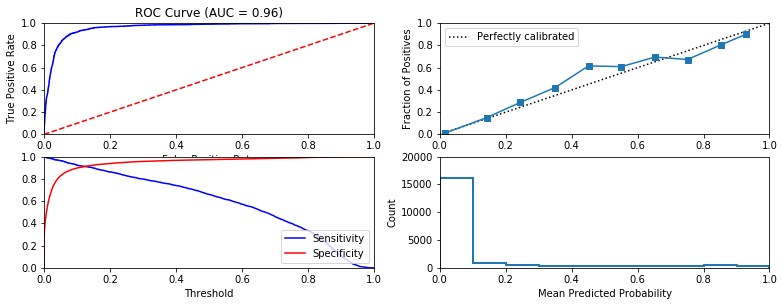


Similarity to LC grade ranking:  -0.0021089735025112146
Brier score: 0.043178487017426506
Were parameters on edge? : False
Score variations around CV search grid : 4.841574310883773
[0.89296667 0.89296667 0.89296667 0.89823333 0.91186667 0.93223333
 0.93703333 0.9382     0.9384     0.938      0.938      0.93826667
 0.93726667 0.9379     0.9384     0.93813333 0.93756667 0.93763333
 0.93833333 0.93763333]


In [22]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS

my_model = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 15.)}

clf_original = fit_classification(my_model, data_dict, cv_parameters, 'random', "Original Data - Random")

### Run the model (Temporal train/test split)

In [23]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS

# 2.2 Temporal training/test split
# find the cut-off date (70%/30%)
data.reset_index(drop=True,inplace=True)
data.sort_values(by="issue_d",inplace=True)
data.reset_index(drop=True,inplace=True)
data['issue_d'][int(len(data)*0.7)]
print(len(data[data['issue_d']>datetime.date(2015, 11, 1)])/len(data))
print(len(data[data['issue_d']>datetime.date(2015, 10, 1)])/len(data))
data['train'] = [False]*len(data)
data['train'][data['issue_d']<=datetime.date(2015, 10, 1)]=True

train = data.train.values

0.5221072933067402
0.5433813772020737


In [24]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS

## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

              Model: Original Data - Temporal
Fit time: 15.71 seconds
Optimal parameters:
{'C': 1000000000.0}

Accuracy-maximizing threshold was: 0.43520298441136673
Accuracy:  0.95165
              precision    recall  f1-score   support

  No default     0.9885    0.9593    0.9737     18641
     Default     0.6026    0.8469    0.7042      1359

   micro avg     0.9516    0.9516    0.9516     20000
   macro avg     0.7956    0.9031    0.8389     20000
weighted avg     0.9623    0.9516    0.9554     20000



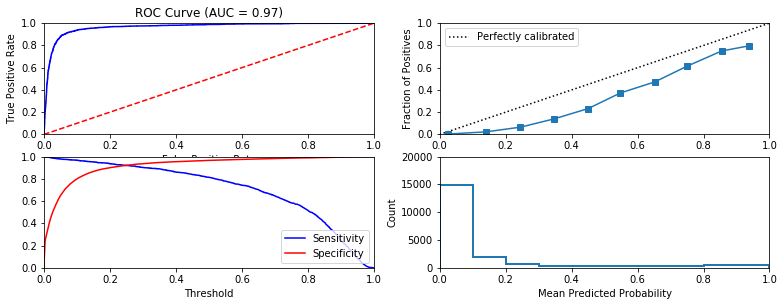


Similarity to LC grade ranking:  0.0028476218728989314
Brier score: 0.035649864771312705
Were parameters on edge? : False
Score variations around CV search grid : 8.557192374350095
[0.8442     0.8442     0.8442     0.8607     0.90203333 0.9197
 0.92263333 0.9231     0.923      0.92313333 0.92296667 0.923
 0.92303333 0.9231     0.9232     0.92313333 0.92313333 0.92303333
 0.92313333 0.9231    ]


In [25]:
# NEEDS TO RERUN THE PREPARATION FUNCTIONS TO DO THIS
my_model = LogisticRegression(penalty='l2')
cv_parameters = {'C':10**np.arange(-5., 15.)}

clf_original = fit_classification(my_model, data_dict, cv_parameters, 'time', "Original Data - Temporal")

## Q7. Test regression models

In [23]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      cv_mode = 'random',
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      data = data,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]
            
            if cv_mode=='random':
                cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
                cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')
                start_time = time.time()
                cv_model_0.fit(X_train_0, y_train_0)
                cv_model_1.fit(X_train_1, y_train_1)
                end_time = time.time()

            elif cv_mode=='time':
                cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2', cv=GroupKFold(n_splits=5))
                cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2', cv=GroupKFold(n_splits=5))
                start_time = time.time()
                try:
                    cv_model_0.fit(X_train_0, y_train_0, groups=data['issue_d'][filter_train][outcome_train == False])
                    cv_model_1.fit(X_train_1, y_train_1, groups=data['issue_d'][filter_train][outcome_train == True])
                except:
                    print('The CV group is incorrect')
                    raise
                end_time = time.time()

            else:
                print('The input CV mode does not exist')
                raise
            
            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("="*80)
                    print(" "*12+"Model: {}  Return column: {}".format(model_name,ret_col))
                    print("="*80)

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            
            if cv_mode=='random':
                cv_model = GridSearchCV(model, cv_parameters, scoring='r2')
                start_time = time.time()
                cv_model.fit(X_train, y_train)
                end_time = time.time()

            elif cv_mode=='time':
                cv_model = GridSearchCV(model, cv_parameters, cv=GroupKFold(n_splits=5))
                start_time = time.time()
                try:
                    cv_model.fit(X_train, y_train, groups=data['issue_d'][filter_train])
                except:
                    print('The CV group is incorrect')
                    raise
                end_time = time.time()

            else:
                print('The input CV mode does not exist')
                raise

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("="*80)
                    print(" "*12+"Model: {}  Return column: {}".format(model_name,ret_col))
                    print("="*80)

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # -----------------------------------------
        #   Step 3 - Output the results to a file
        # -----------------------------------------
        
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### Reprocess the splits and the features

In [24]:
# 2.2 Temporal training/test split
# find the cut-off date (70%/30%)
data.sort_values(by="issue_d",inplace=True)
data.reset_index(drop=True,inplace=True)
data['issue_d'][int(len(data)*0.7)]
print(len(data[data['issue_d']>datetime.date(2015, 11, 1)])/len(data))
print(len(data[data['issue_d']>datetime.date(2015, 10, 1)])/len(data))
data['train'] = [False]*len(data)
data['train'][data['issue_d']<=datetime.date(2015, 10, 1)]=True

train = data.train.values

0.28767964478454433
0.30862133933661196


In [25]:
## define your set of features to use in different models
grade_dummies = [v for v in discrete_features_dummies if v.split("::")[0] == 'grade']
your_features = list(set(continuous_features+discrete_features_dummies)-set(grade_dummies)-set(['dti']))

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### $l_1$ regularized linear regression

In [26]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha':10**np.arange(-10., 0.)}

print("***Integrated Training***")
reg_lasso = fit_regression(Lasso(), data_dict, cv_parameters, 'time', False, "l1 Linear Regression")
print("\n***Separate Training:***")
reg_lasso = fit_regression(Lasso(), data_dict, cv_parameters, 'time', True, "l1 Linear Regression")

***Integrated Training***
            Model: l1 Linear Regression  Return column: ret_PESS
Fit time: 23.45 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: -0.23108210412120367
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -57.41815382538145
All test scores : [-0.00102162 -0.00102162 -0.00102161 -0.00102159 -0.00101554 -0.00099701
 -0.00115205 -0.00156947 -0.00156947 -0.00156947]
            Model: l1 Linear Regression  Return column: ret_OPT
Fit time: 33.1 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: -0.024477987451047678
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -130.42837354547132
All test scores : [-0.00056584 -0.00056583 -0.00056571 -0.00056448 -0.00055457 -0.00043867
 -0.00024556 -0.00028159 -0.00028159 -0.00028159]
            Model: l1 Linear Regression  Return column: ret_INTa
Fit time: 23.44 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score

### $l_2$ regularized linear regression

In [33]:
# ## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha':10**np.arange(-10., 0.)}

print("***Integrated Training***")
reg_ridge = fit_regression(Ridge(), data_dict, cv_parameters, 'time', False, "l2 Linear Regression")
print("\n***Separate Training:***")
reg_ridge = fit_regression(Ridge(), data_dict, cv_parameters, 'time', True, "l2 Linear Regression")

***Integrated Training***
            Model: l2 Linear Regression  Return column: ret_PESS
Fit time: 0.7 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: -0.2320929701751442
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -16.16384361979876
All test scores : [-0.00090343 -0.00090342 -0.00090336 -0.00090278 -0.00089766 -0.00088437
 -0.00096486 -0.00102007 -0.00102731 -0.00102292]
            Model: l2 Linear Regression  Return column: ret_OPT
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: -0.024731389962065142
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -13.419746361238234
All test scores : [-0.00055055 -0.00055054 -0.00055045 -0.00054954 -0.00054122 -0.00050433
 -0.00053177 -0.00056732 -0.000572   -0.00056718]
            Model: l2 Linear Regression  Return column: ret_INTa
Fit time: 0.83 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: -0.

### Multi-layer perceptron regression

In [61]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'activation':['identity','relu','logistic'],'alpha':([[10]]**np.arange(-6.,-1)).ravel()}

print("***Integrated Training***")
reg_mlp_all = fit_regression(MLPRegressor(), data_dict, cv_parameters, 'time', False, "Multi-layer Perceptron Regression")
print("\n***Separate Training:***")
reg_mlp_sepa = fit_regression(MLPRegressor(), data_dict, cv_parameters, 'time', True, "Multi-layer Perceptron Regression")

***Integrated Training***
            Model: Multi-layer Perceptron Regression  Return column: ret_PESS
Fit time: 117.25 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.01}

Testing r2 score: -0.32282898678864225
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -685.674741320702
All test scores : [-0.01340145 -0.02106586 -0.06261298 -0.03364081 -0.00796933 -0.02144106
 -0.0259007  -0.02025065 -0.03397652 -0.009915   -0.00899784 -0.01787199
 -0.02175953 -0.0442991  -0.01674591]
            Model: Multi-layer Perceptron Regression  Return column: ret_OPT
Fit time: 145.92 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001}

Testing r2 score: -0.003123910996971402
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -371.3243615120104
All test scores : [-0.0202175  -0.00727028 -0.01367221 -0.01685208 -0.01016394 -0.01451427
 -0.0129695  -0.0094997  -0.01130112 -0.02016801 -0.0077

### Random forest regression

In [32]:
## trying random forest regression with hyper-parameters

cv_parameters = {'n_estimators':[20,50,100],'max_depth':np.arange(6,8)}

print("***Integrated Training***")
reg_rf = fit_regression(RandomForestRegressor(), data_dict, cv_parameters, 'time', False, "Random forest regression")
print("\n***Separate Training:***")
reg_rf = fit_regression(RandomForestRegressor(), data_dict, cv_parameters, 'time', True, "Random forest regression")

***Integrated Training***
            Model: Random forest regression  Return column: ret_PESS
Fit time: 376.28 seconds
Optimal parameters:
{'max_depth': 6, 'n_estimators': 100}

Testing r2 score: -0.22793543888569645
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -326.4050014731021
All test scores : [-0.00150862 -0.00077039 -0.00039995 -0.00170539 -0.00097743 -0.00050156]
            Model: Random forest regression  Return column: ret_OPT
Fit time: 397.47 seconds
Optimal parameters:
{'max_depth': 6, 'n_estimators': 100}

Testing r2 score: -0.023777584204915048
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -615.7947855905802
All test scores : [-0.00157197 -0.00055986 -0.00050918 -0.00364471 -0.0014974  -0.00124814]
            Model: Random forest regression  Return column: ret_INTa
Fit time: 333.94 seconds
Optimal parameters:
{'max_depth': 6, 'n_estimators': 100}

Testing r2 score: -0.21040166434533059


## Q8. Test investment strategies 
Now we test several investment strategies using the learning models above

In [70]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
          
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [79]:
## Test investment strategies using the best performing regressor

# col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
# test_strategy = 'Random'

# print('strategy:',test_strategy)   
# strat_rand = test_investments(...)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
    
    
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)

result = {}
for ret_col in col_list:
    result[ret_col] = []
    
for i in range(2, 102):

    strat_def = test_investments(data_dict, l2_logistic,reg_mlp_all, test_strategy, random_state = i)
    
    for ret_col in col_list:
        result[ret_col].append(strat_def[ret_col]['average return'])
        
for ret_col in col_list:
    print(ret_col + ': ' + str(np.mean(result[ret_col])))

strategy: Random
ret_PESS: -0.031400999710225024
ret_OPT: 0.029548669808140134
ret_INTa: -0.0007061215900709634
ret_INTb: 0.03373819369279293


In [78]:
test_strategy = 'Default-based'
print('strategy:',test_strategy)

result = {}
for ret_col in col_list:
    result[ret_col] = []
    
for i in range(2, 102):

    strat_def = test_investments(data_dict, l2_logistic,reg_mlp_all, test_strategy, random_state = i)
    
    for ret_col in col_list:
        result[ret_col].append(strat_def[ret_col]['average return'])
        
for ret_col in col_list:
    print(ret_col + ': ' + str(np.mean(result[ret_col])))

strategy: Default-based
ret_PESS: -0.03029375041717747
ret_OPT: 0.028769275949158516
ret_INTa: -0.002050620957839811
ret_INTb: 0.03583321725187327


In [81]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)

result = {}
for ret_col in col_list:
    result[ret_col] = []
    
for i in range(2, 102):

    strat_def = test_investments(data_dict, l2_logistic,reg_mlp_all, test_strategy, random_state = i)
    
    for ret_col in col_list:
        result[ret_col].append(strat_def[ret_col]['average return'])
        
for ret_col in col_list:
    print(ret_col + ': ' + str(np.mean(result[ret_col])))

strategy: Return-based
ret_PESS: -0.03687139344663411
ret_OPT: 0.032663626138998224
ret_INTa: 0.00028587487891863544
ret_INTb: 0.034865701338644625


In [71]:
test_strategy = 'Default-return-based'

print('strategy:',test_strategy)

result = {}
for ret_col in col_list:
    result[ret_col] = []
    
for i in range(2, 102):

    strat_def = test_investments(data_dict, l2_logistic,reg_mlp_sepa, test_strategy, random_state = i)
    
    for ret_col in col_list:
        result[ret_col].append(strat_def[ret_col]['average return'])
        
for ret_col in col_list:
    print(ret_col + ': ' + str(np.mean(result[ret_col])))

strategy: Default-return-based
ret_PESS: -0.03668812775165305
ret_OPT: 0.02499312128089345
ret_INTa: -0.0053559958787375945
ret_INTb: 0.03733956345507487


## Q9. Sensitivity test of portfolio size

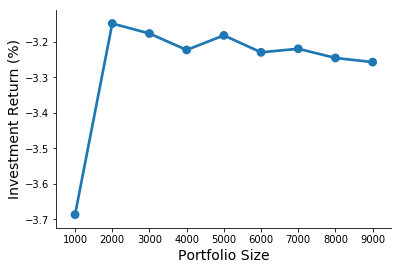

In [83]:
## Test the best-performing data-driven strategy on different portfolio sizes
test_strategy = 'Return-based'
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, l2_logistic,reg_mlp_all, test_strategy, num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()